## Init

In [0]:
! wget --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&confirm='"$(wget --save-cookies cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')"'&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O img_align_celeba.zip
! unzip -q img_align_celeba
! mkdir test
! mv img_align_celeba test
! pip3 install torch
! pip3 install torchvision

In [0]:
import os
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

## Modules

In [0]:
class CelebaDataset(Dataset):
  def __init__(self, root, size=128, train=True):
    super(CelebaDataset, self).__init__()
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root) ,transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))
  def __getitem__(self,index):
    index += 97
    img = self.dataset_folder[index]
    return img[0]
 
  def __len__(self):
    return len(self.dataset_folder) - 525

In [0]:
# Critic Module
class Critic(nn.Module):
  def __init__(self, batch):
    super(Critic, self).__init__()
    self.batch = batch
    
    self.net = nn.Sequential(
      nn.Conv2d(3, 128, 2, stride=2),  
      nn.LeakyReLU(),
      nn.Conv2d(128, 256, 2, stride=2),  
      nn.LeakyReLU(),
      nn.Conv2d(256, 512, 2, stride=2),  
      nn.LeakyReLU(),
      nn.Conv2d(512, 1024, 2, stride=2),  
      nn.LeakyReLU()
    )
    self.project = nn.Linear(65536, 1)
    
  def forward(self, x):
    out = self.net(x).reshape(self.batch, 65536)
    return self.project(out)

In [0]:
# Generator Module
class Generator(nn.Module):
  def __init__(self, batch):
    super(Generator, self).__init__()
    self.batch = batch
    
    self.project = nn.Sequential(
      nn.Linear(100, 65536),
      nn.LeakyReLU()
    )
    self.net = nn.Sequential(
      nn.ConvTranspose2d(1024, 512, 2, stride=2),  
      nn.LeakyReLU(),
      nn.ConvTranspose2d(512, 256, 2, stride=2),  
      nn.LeakyReLU(),
      nn.ConvTranspose2d(256, 128, 2, stride=2),  
      nn.LeakyReLU(),
      nn.ConvTranspose2d(128, 3, 2, stride=2),  
      nn.LeakyReLU(),
      nn.Sigmoid()
    )
    
  def forward(self, x):
    out = self.project(x).reshape(self.batch, 1024, 8, 8)
    return self.net(out)
    

## Train

In [0]:
def train(lamb, learning_rate, batch_size, epochs, critic_iters, 
          model_g, model_c, optim_g, optim_c, loader, distribution, losses_c, losses_g):
  for epoch in range(epochs): 
    loop = tqdm(total=len(loader), position=0, leave=False)

    for true_img in loader:
      true_img = true_img.cuda()
      if len(true_img) != batch_size:
        break

      #train discriminator#
      for p in model_c.parameters():
        p.requires_grad = True

      for p in model_g.parameters():
        p.requires_grad = False

      for n in range(critic_iters):
        optim_c.zero_grad()

        z = distribution.rsample(torch.Size([batch_size])).cuda()
        e = torch.rand(batch_size, 1, 1, 1).cuda()

        gen_img = model_g(z)
        x_hat = (e * true_img + (1 - e) * gen_img).requires_grad_()

        critique = model_c(x_hat)
        grad = torch.autograd.grad(critique, x_hat, 
                                   grad_outputs=torch.ones(critique.size()).cuda(), 
                                   create_graph=True)[0]

        loss_c = (model_c(gen_img) - model_c(true_img) + (lamb * (torch.norm(grad, p=2) - 1)) ** 2).mean()

        loss_c.backward()
        optim_c.step()
        losses_c.append(loss_c.item())

      #train generator# 
      for p in model_g.parameters():
        p.requires_grad = True

      for p in model_c.parameters():
        p.requires_grad = False

      optim_g.zero_grad()

      z = distribution.rsample(torch.Size([batch_size])).cuda()
      gen_img = model_g(z)

      loss_g = (-model_c(gen_img)).mean()

      loss_g.backward()
      optim_g.step()
      losses_g.append(loss_g.item())

      loop.set_description('epoch:{}, crtique loss:{:.4f}, generator loss:{:.4f}, memory:{:.4f}'
                             .format(epoch, loss_c.item(), loss_g.item(), torch.cuda.memory_allocated(0) / 1e9))
      loop.update(1)

## Main

In [22]:
lamb = 10
learning_rate = 0.0002 
batch_size = 64
epochs = 3
critic_iters = 1

#initialize generator and discriminator models
model_g = Generator(batch_size).cuda()
model_c = Critic(batch_size).cuda()

#initialize separate optimizer for both gen and disc
optim_g = torch.optim.Adam(model_g.parameters(), lr=learning_rate)
optim_c = torch.optim.Adam(model_c.parameters(), lr=learning_rate)

#initialize dataset and dataloader
dataset = CelebaDataset("/")
loader = DataLoader(dataset, batch_size=batch_size)
distribution = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(100), torch.eye(100))

gc.collect()
print(torch.cuda.memory_allocated(0) / 1e9)

losses_c = []
losses_g = []

try:
  train(lamb, learning_rate, batch_size, epochs, critic_iters, model_g, model_c, 
        optim_g, optim_c, loader, distribution, losses_c, losses_g)
except Exception as e:
  print("Early stop: " + str(e))

  0%|          | 0/6331 [00:00<?, ?it/s]

0.419585536


epoch:2, crtique loss:0.1260, generator loss:16.4428, memory:0.6656: 100%|█████████▉| 6330/6331 [1:49:29<00:01,  1.03s/it]

## Results

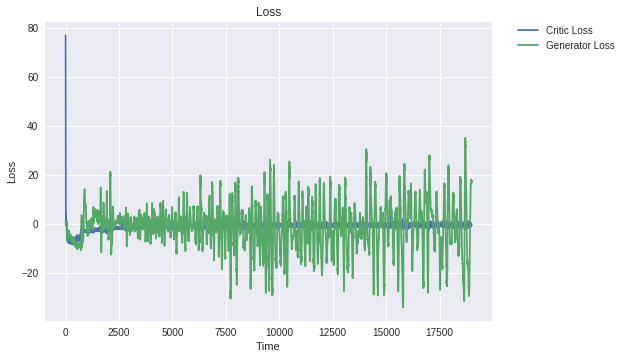

Generated Images


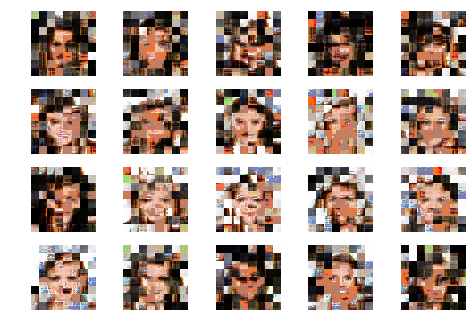

Interpolated Images


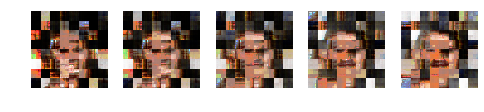

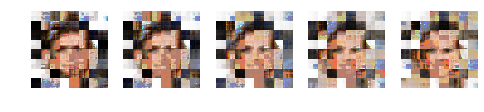

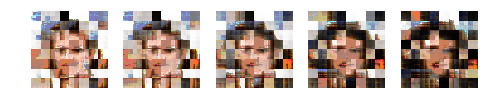

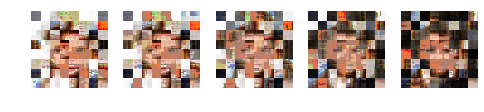

In [35]:
# Plot results
plt.plot(losses_c, label="Critic Loss")
plt.plot(losses_g, label="Generator Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Loss")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.show()

# Image Grid
print("Generated Images")
fig = plt.figure()
for i in range(20):
  z = distribution.rsample(torch.Size([batch_size])).cuda()
  gen_imgs = model_g(z)
  img = gen_imgs[0].cpu().permute(1,2,0).detach()
  fig.add_subplot(4, 5, i + 1)
  plt.imshow(img)
  plt.axis("off")
plt.show()

# Interpolation
print("Interpolated Images")
samples = distribution.rsample(torch.Size((4, 2))).cuda()
for row in range(4):
  z1 = samples[row][0]
  z2 = samples[row][1]
  z_list = torch.zeros(batch_size, 100).cuda()
  for i in range(batch_size):
    z_list[i] = z1 * i / batch_size + z2 * (1 - i / batch_size)
  gen_imgs = model_g(z_list)
  fig = plt.figure()
  for col in range(5):
    fig.add_subplot(1, 5, col + 1)
    plt.imshow(gen_imgs[int(batch_size * col / 5)].cpu().permute(1,2,0).detach())
    plt.axis("off")
  plt.show()